In [1]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline

In [34]:
df = pd.read_csv('bbc-text.csv')

In [35]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [36]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [37]:
df_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [38]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [39]:
df_clean.head()

,text,text_lemmatize
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tiger wary farrell gamble leicester say rush m...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [40]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [41]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

24578

In [42]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [44]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=100,
                     window=5,
                     size=100,
                     workers=4)

In [45]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [46]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(8216157, 14282670)

In [47]:
w2v_model.init_sims(replace=True)

In [48]:
w2v_model.wv.most_similar(positive=['economy'])

[('economic', 0.7291756272315979),
 ('export', 0.6035723090171814),
 ('growth', 0.5296380519866943),
 ('economist', 0.5142301917076111),
 ('domestic', 0.4977671504020691),
 ('forecast', 0.47376060485839844),
 ('rise', 0.4624667167663574),
 ('slow', 0.4622381925582886),
 ('sector', 0.4385509192943573),
 ('deficit', 0.4193621873855591)]

In [49]:
w2v_model.wv.most_similar(positive=['president'])

[('bush', 0.5114681720733643),
 ('chief', 0.3103163242340088),
 ('america', 0.3006551265716553),
 ('production', 0.2966122627258301),
 ('german', 0.27125829458236694),
 ('response', 0.27021950483322144),
 ('state', 0.266130268573761),
 ('oil', 0.2628362774848938),
 ('senior', 0.26177141070365906),
 ('leader', 0.26056694984436035)]

In [58]:
w2v_model.wv.similarity('video', 'gaming')

0.53939295

In [51]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


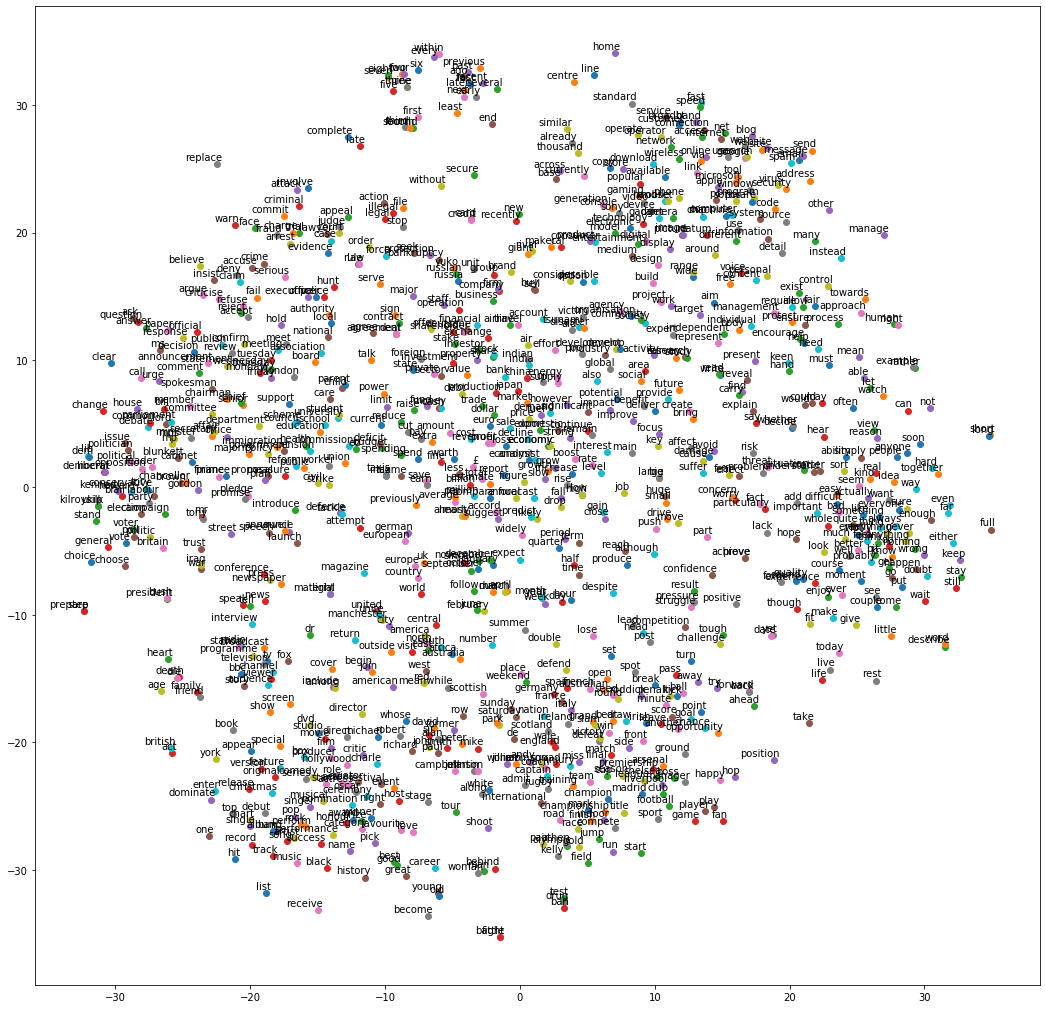

In [52]:
tsne_plot(w2v_model)

In [4]:
from gensim.models import KeyedVectors

filename = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192315101624)]
